### Bizbuysell Data Wrangling & Exploration 3

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import seaborn as sns
import h3

### Load dataset

In [3]:
df_in=pd.read_parquet('data/bizbuysell.dataset.2.parquet')

In [4]:
df_in.shape

(252852, 33)

In [5]:
df_in.head()

,id,src,url,title,desc,local,region,location,title_loc,categories,...,COUNTY_SEQUENCE,COUNTY_NUMERIC,COUNTY_NAME,PRIMARY_LATITUDE,PRIMARY_LONGITUDE,DATE_CREATED,DATE_EDITED,STATE_NAME,POVERTY_PERCENT,MEDIAN_HOUSEHOLD_INCOME
0,2067319.0,details,https://www.bizbuysell.com/Business-Real-Estat...,Popular Marina in Central New Jersey in Middle...,It is fully owned by a man and his wife since ...,Middlesex,New Jersey,"Middlesex County, NJ","Central New Jersey in Middlesex County, New Je...","[Real Estate For Sale, New Jersey, Marinas and...",...,1.0,23.0,Middlesex,40.572603,-74.492654,09/08/1979,03/17/2008,New Jersey,8.0,98992.0
1,1990890.0,details,https://www.bizbuysell.com/Business-Real-Estat...,"High Exposure in Mays Landing, New Jersey - Bi...",AMAZING OPPORTUNITY! Priced to sell and ready ...,Mays Landing,New Jersey,"Mays Landing, NJ (Atlantic County)","Mays Landing, New Jersey","[Real Estate For Sale, New Jersey, Other, Mays...",...,1.0,1.0,Atlantic,39.452339,-74.727663,09/08/1979,12/06/2013,New Jersey,15.1,65693.0
2,2050006.0,details,https://www.bizbuysell.com/Business-Real-Estat...,"Rental Units with Real Estate in Randolph, New...",This is a 6 unit Airbnb with an average occupa...,Randolph,New York,"Randolph, NY (Cattaraugus County)","Randolph, New York","[Real Estate For Sale, New York, Hotels, Rando...",...,1.0,9.0,Cattaraugus,42.162005,-78.975317,01/23/1980,11/08/2019,New York,16.1,54602.0
3,2039720.0,details,https://www.bizbuysell.com/Business-Real-Estat...,"Duplex, Short term or Long term in Pinellas Co...",Rare Largo/Seminole area duplex centrally loca...,Pinellas,Florida,"Pinellas County, FL","Pinellas County, Florida","[Real Estate For Sale, Florida, Other, Pinella...",...,1.0,103.0,Pinellas,27.905111,-82.799568,08/28/1987,06/04/2021,Florida,12.3,61851.0
4,1576680.0,details,https://www.bizbuysell.com/Business-Real-Estat...,"Major Price Reduction Rest/Tavern/ 13,000sq. f...",Price reduced to $850. 000 MAKE AN OFFER!!!!!!...,Baltimore,Maryland,"Baltimore, MD (Baltimore City County)","Baltimore, Maryland","[Real Estate For Sale, Maryland, Bars, Pubs an...",...,1.0,510.0,Baltimore (city),39.290385,-76.612189,09/12/1979,03/17/2008,Maryland,22.9,54068.0


### Drop duplicate or missing listing ids

In [6]:
dfa=df_in.drop_duplicates('id')
dfa=dfa.dropna(subset=['id'])

In [7]:
dfa.shape

(33774, 33)

### Drop missing/zero/negative price

In [8]:
dfb=dfa.dropna(subset=['price'])
dfb=dfb.query('price > 0')

In [9]:
dfb.shape

(33598, 33)

### Get rid of franchise, lease, auction, rent

In [10]:
dfc=dfb
dfc['franchise']=dfc.title.str.contains("franchise", case=False)
dfc['lease']=dfc.title.str.contains("lease", case=False)
dfc['auction']=dfc.title.str.contains("auction", case= False)
dfc['rent']=dfc.title.str.contains("rent", case= False)

In [11]:
dfc=dfc.loc[(dfc.franchise==False)&(dfc.lease==False)&(dfc.auction==False)&(dfc.rent==False)]
#dfc=dfc.loc[(dfc.lease==False)&(dfc.auction==False)&(dfc.rent==False)]
dfc=dfc.drop(columns=['franchise','lease','auction','rent'])

In [12]:
dfc.shape

(30657, 33)

### Get rid of price anomalies with IQR

In [13]:
Q1 = dfc.price.quantile(0.25)
Q3 = dfc.price.quantile(0.75)
IQR = Q3 - Q1

dfd = dfc.query('(@Q1 - 1.5 * @IQR) <= price <= (@Q3 + 1.5 * @IQR)')

In [14]:
dfd.shape

(27338, 33)

<AxesSubplot:xlabel='price', ylabel='Count'>

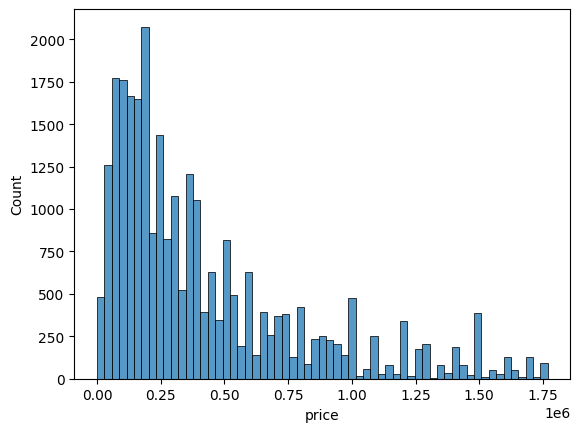

In [15]:
sns.histplot(data=dfd, x="price")

### Add H3 index level 15
see: https://h3geo.org/docs/core-library/restable/

In [16]:
dfe=dfd
dfe['15']=15
dfe['lat_lon_15']= dfe[['PRIMARY_LATITUDE','PRIMARY_LONGITUDE','15']].values.tolist()
dfe['H3_15']=dfe['lat_lon_15'].apply(lambda x: h3.geo_to_h3(*x))
dfe=dfe.drop(columns=['15','lat_lon_15'])

<AxesSubplot:xlabel='PRIMARY_LONGITUDE', ylabel='PRIMARY_LATITUDE'>

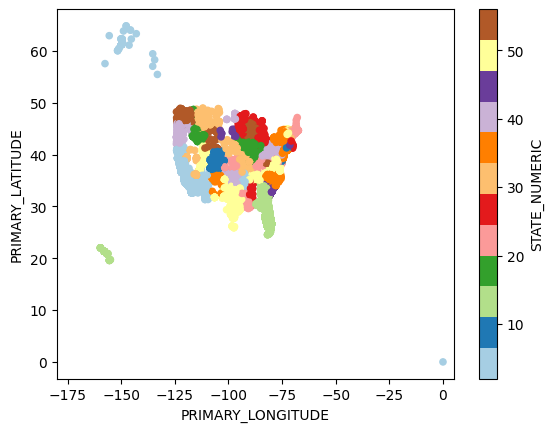

In [17]:
dfe.plot(x="PRIMARY_LONGITUDE", y="PRIMARY_LATITUDE", 
        kind="scatter", c="STATE_NUMERIC", colormap="Paired",xlim=(-180,5))

In [18]:
dfe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27338 entries, 1 to 208608
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       27338 non-null  float64
 1   src                      27338 non-null  object 
 2   url                      27338 non-null  object 
 3   title                    27338 non-null  object 
 4   desc                     27338 non-null  object 
 5   local                    27338 non-null  object 
 6   region                   27338 non-null  object 
 7   location                 27338 non-null  object 
 8   title_loc                27281 non-null  object 
 9   categories               27338 non-null  object 
 10  similar                  27338 non-null  object 
 11  details                  27338 non-null  object 
 12  financials               27338 non-null  object 
 13  price                    27338 non-null  float64
 14  FEATURE_ID           

In [19]:
df_out=dfe

### Save processed data to parquet file

In [20]:
df_out.to_parquet('data/bizbuysell.dataset.3.parquet')